In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def img_show(img):
    plt.figure("Image") # 图像窗口名称
    plt.imshow(img)
    plt.axis('off') # 关掉坐标轴为 off
    plt.show()

color_dist = {'red': {'Lower': np.array([0, 60, 60]), 'Upper': np.array([6, 255, 255])},
              'gray': {'Lower': np.array([0, 0, 46]), 'Upper': np.array([180, 43, 220])},
              'yellow': {'Lower': np.array([26, 43, 46]), 'Upper': np.array([34, 255, 255])},          
              'blue': {'Lower': np.array([100, 80, 46]), 'Upper': np.array([124, 255, 255])},
              'green': {'Lower': np.array([35, 43, 35]), 'Upper': np.array([90, 255, 255])},}

# 摄像头内参
mtx = np.array([[1.35635605e+03, 0.00000000e+00, 6.46212314e+02],
       [0.00000000e+00, 1.35578874e+03, 3.78009469e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

dist = np.array([[-2.52464877e-01, 1.92828476e-01, -6.55508668e-04, 2.48903668e-03, -7.45335496e-01]])

img = cv2.imread("./imgsrc/1.jpg")

dst = cv2.undistort(img, mtx, dist, None, mtx)

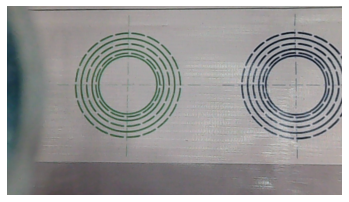

In [2]:
# cap = cv2.VideoCapture(0)
# ret, img = cap.read()
# dst = cv2.undistort(img, mtx, dist, None, mtx)
img_show(dst)

In [5]:

codeinfo, points, straight_qrcode = cv2.QRCodeDetector().detectAndDecode(dst)

Library QUIRC is not linked. No decoding is performed. Take it to the OpenCV repository.


In [ ]:

hsv_img = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)

inRange_hsv = cv2.inRange(hsv_img, color_dist['green']['Lower'], color_dist['green']['Upper'])

In [ ]:
img_show(inRange_hsv)

In [ ]:
circle = cv2.HoughCircles(inRange_hsv, cv2.HOUGH_GRADIENT, 1, 50,
                         param1=100, param2=80, minRadius=60, maxRadius=200)

print(type(circle))

In [ ]:
dst1 = dst

In [ ]:
# 将检测结果绘制在图像上
for i in circle[0, :]:  # 遍历矩阵的每一行的数据
    # 绘制圆形
    cv2.circle(dst1, (int(i[0]), int(i[1])), int(i[2]), (255, 0, 0), 10)
    # 绘制圆心
    cv2.circle(dst1, (int(i[0]), int(i[1])), 10, (255, 0, 0), -1)

img_show(dst1)

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,img_bin=cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
img_dst = cv2.medianBlur(img_gray, 7)